# 02-Data Preparation

_[Estimated execution time: 3 min]_

This notebook show how manipulate data before training, this notebook will include:

* Filter data by ranges.
* Aggregate data.
* Randomly remove observations.
* Apply data transformations.

In [1]:
import mogptk

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# plot config
# uncomment for better plots
sns.set_context('notebook', font_scale=1.2)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

### Data load

First we load the Gold, Oil, NASDAQ and USD dataset, this dataset constains daily index prices of Gold, Oil, NASDAQ USD from ~1980  to 2019.

This way we create a [`mogptk.DataSet`](https://games-uchile.github.io/mogptk/dataset.html) which acts as an iterable where each element is a [`mogptk.Data`](https://games-uchile.github.io/mogptk/data.html) object, containing the points for said channel.

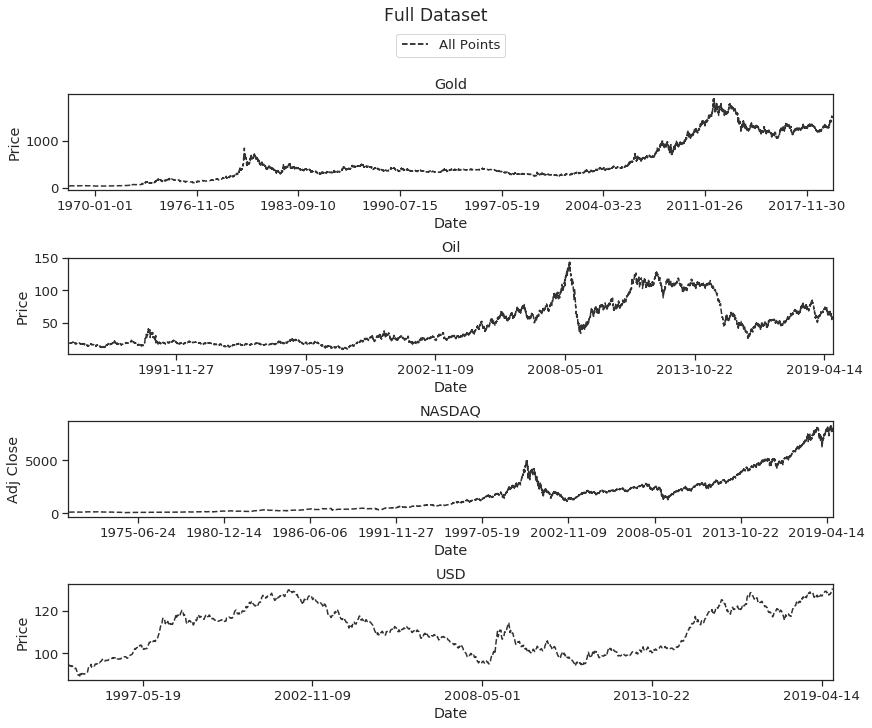

In [3]:
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      name='Gold',
                      formats={'Date': mogptk.FormatDate},
                      **{'na_values':'.'},)
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     name='Oil',
                     formats={'Date': mogptk.FormatDate})
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        name='NASDAQ',
                        formats={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     name='USD',
                     formats={'Date': mogptk.FormatDate})

# create dataset
dataset = mogptk.DataSet(gold, oil, nasdaq, usd)
# plot
dataset.plot('Full Dataset', figsize=(12, 10));

## Data filtering


We know filter for each channel between the years 2015 and 2018 using the method of the data class [`mogptk.Data.filter`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.filter).

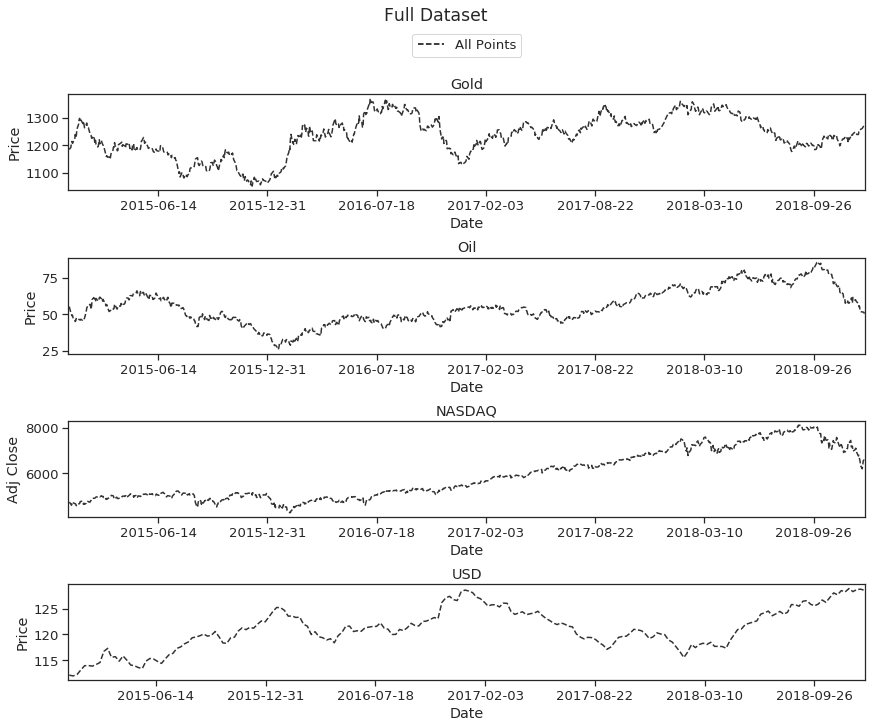

In [4]:
# for each channel we apply the filter method
for channel in dataset:
    channel.filter('2015-01-01', '2018-12-31')

dataset.plot('Full Dataset', figsize=(12, 10));

## Data aggregation

In order to reduce the number of points we will agregate the data by taking the mean value each 7 days using the Data class method [`mogptk.Data.aggregate`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.aggregate)

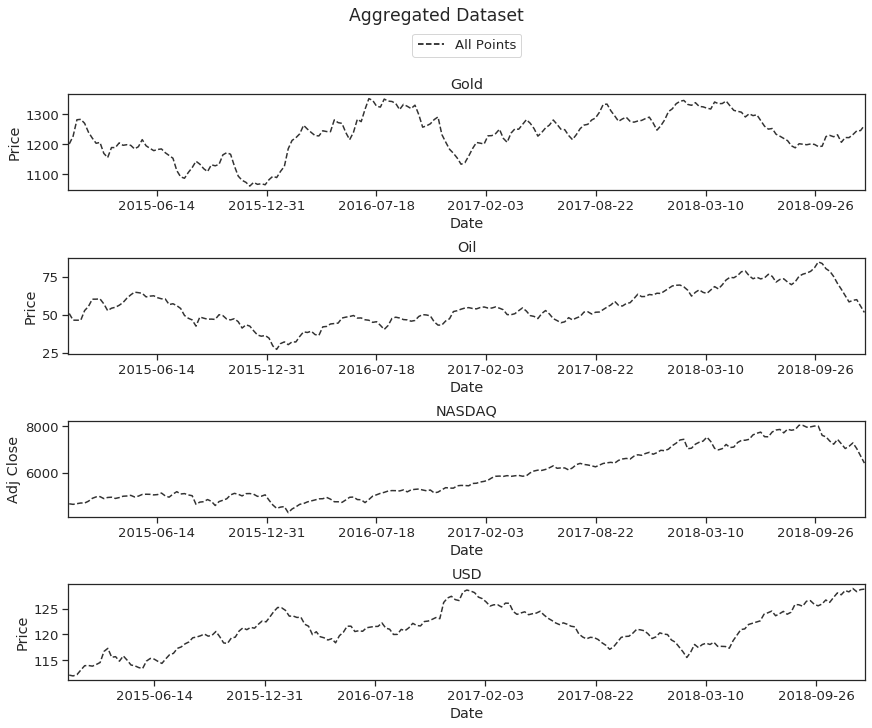

In [5]:
# for each channel we apply the filter method
for channel in dataset:
    channel.aggregate('7d')

dataset.plot('Aggregated Dataset', figsize=(12, 10));

## Data removal

Now to simulate missing values, we will for each channel remove different number of points, with [`mogptk.Data.remove_randomly`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_randomly) we can remove fractions of the data randomly, and with [`mogptk.Data.remove_range`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_range) set a range (date or float values) in which values in said range are removed. 

In practice this points are not erased but a boolean-mask is created, this is contained in the atribute `mogptk.Data.mask`

At this point, the [`mogptk.DataSet.plot`](https://games-uchile.github.io/mogptk/data.html#mogptk.dataset.DataSet.plot) will treat the non-removed points as training points, but will show the complete dataset in solid line.

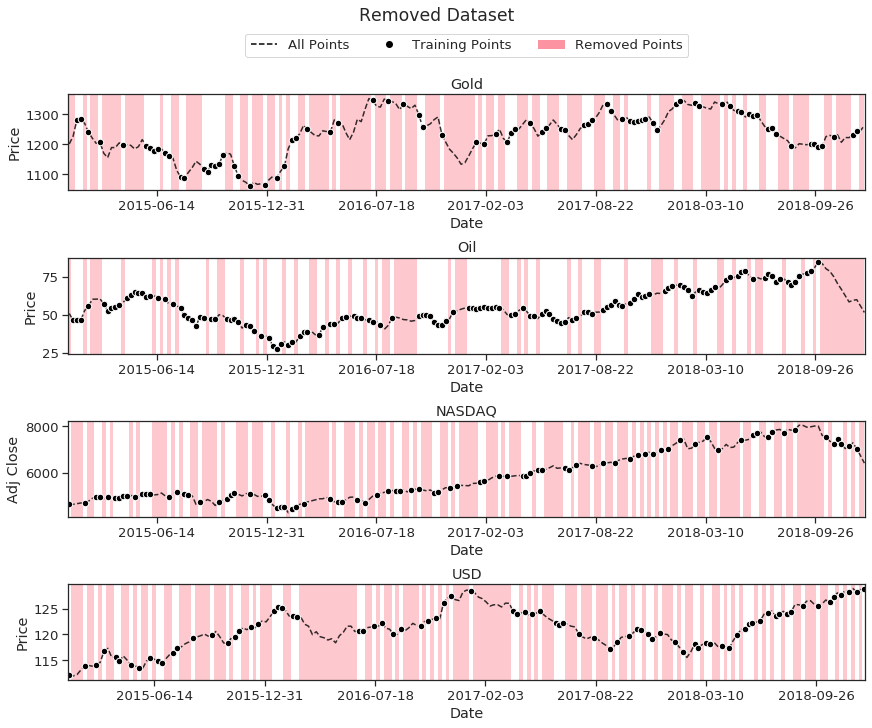

In [6]:
for i, channel in enumerate(dataset):        
    if i == 0:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 1:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 2:
        channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
dataset.plot('Removed Dataset', figsize=(12, 10));

## Transformations

We can see there is clearly a trend in the data, we can remove it using **transformations**, we will detrend the data by performing a polinomial regression of order 1.

The transformations has to have inverse ir order to obtain the regression processes in the original domain.
The toolkit will perform the multioutput regression in the transformed space and then transform the process back to the original space.

Transformations available are:
* [`mogptk.TransformDetrend`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformDetrend): detrend by fitting a polynomial of given degree.
* [`mogptk.TransformNormalize`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformNormalize): Normalize so the data is in [-1, 1].
* [`mogptk.TransformLog`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformLog): Take the log of the data.
* [`mogptk.TransformWhiten`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformWhiten): Whiten the data so that it has a zero mean and a variance of one.
* [`mogptk.TransformLinear`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.TransformLinear): Linearly transform the data given `a` and `b` so that `y => a*y + b`.

**_New transformations_** classes can be implemented by defining 3 methods.

* `set_data()` : sets the data in order to obtain parameters of the transformations (e.g the mean of a normalization or coefficients of a linear regression)
* `forward()`: apply the transformations 
* `backward()`: apply the inverse transformations

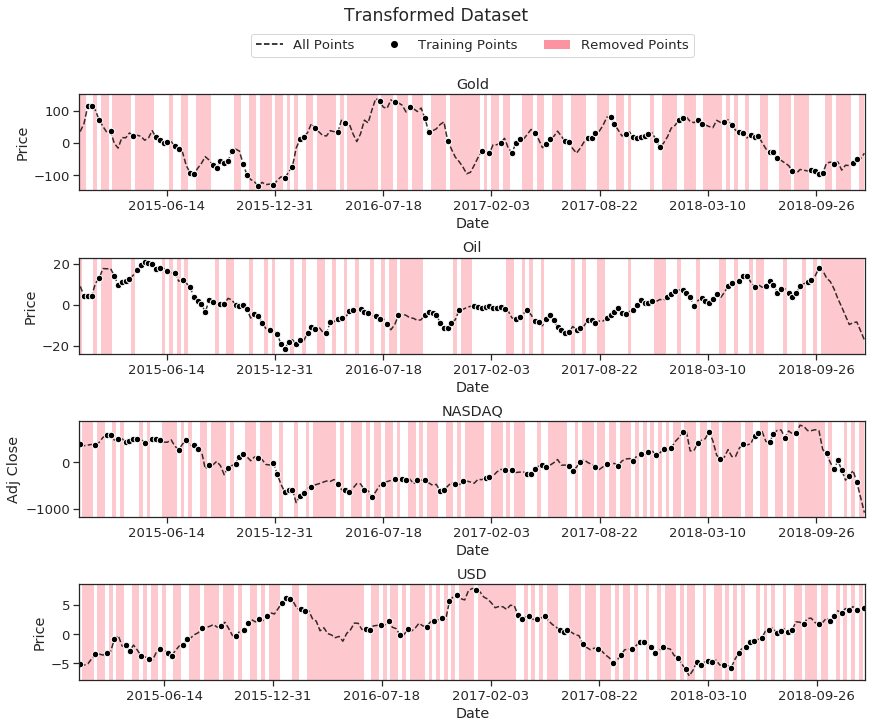

In [7]:
for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    
dataset.plot('Transformed Dataset', figsize=(12, 10));

We would want to normalize the data so it has mean zero and unitary variance, we can implement a transformation for that.

We create a class so that the `set_data()` method takes as argument a `mogptk.Data` object and from that we will obtain the mean and variance of the observations.

We can access the function values with the attribute `mogptk.Data.Y`

In [8]:
class TransformWhiten(mogptk.TransformBase):
    """
    Transform the data so it has mean 0 and variance 1
    """
    def __init__(self):
        pass
    
    def set_data(self, data):
        # take only the non-removed observations
        self.mean = data.Y[data.mask].mean()
        self.std = data.Y[data.mask].std()
        
    def forward(self, y, x=None):
        return (y - self.mean) / self.std
    
    def backward(self, y, x=None):
        return (y * self.std) + self.mean

Now we apply the transformation and also a log transformation

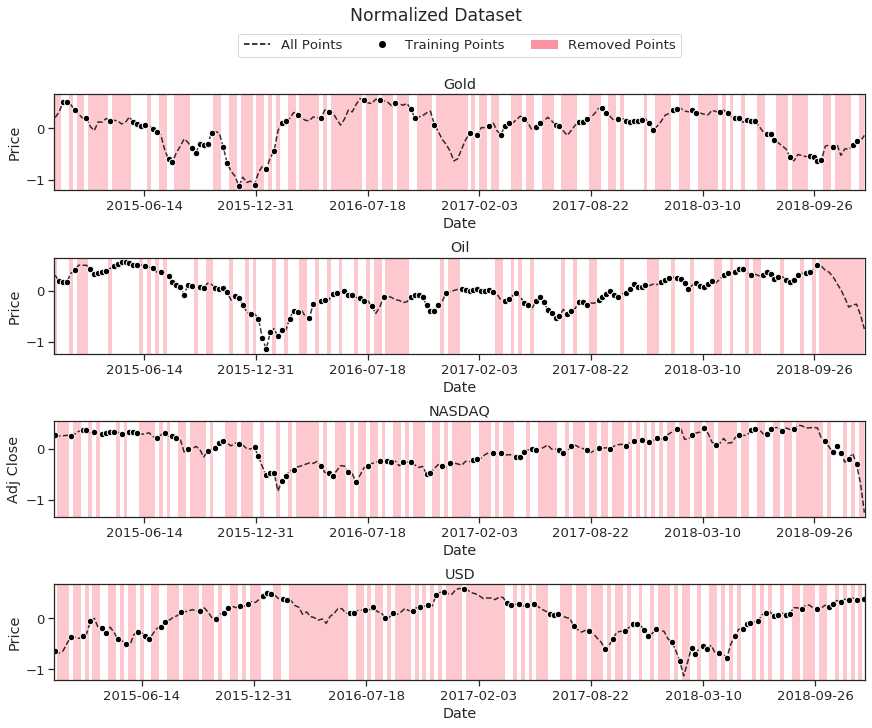

In [9]:
for channel in dataset:
    channel.transform(TransformWhiten())
    channel.transform(mogptk.TransformLog())
    
dataset.plot('Normalized Dataset', figsize=(12, 10));

## Training

With the final dataset we can train the model, this will be trained using the transformed dataset, but the predictions will be shown in the original space by using the inverse transforms

In [10]:
# create model
model = mogptk.MOSM(dataset, Q=3)

# initial estimation of parameters before training
model.init_parameters()

# train
model.train(maxiter=500, verbose=True)

Starting optimization
 >Model: MOSM
 >Channels: 4                    
 >Components: 3
 >Training points: 382
 >Parameters: 65
 >Initial NLL: 376.522
Optimization finished in 1.60 minutes
 >Final NLL: -338.969 



Instead of passing directly the inputs for predictions we can set them using [`mogptk.Data.set_prediction_range`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.set_prediction_range)

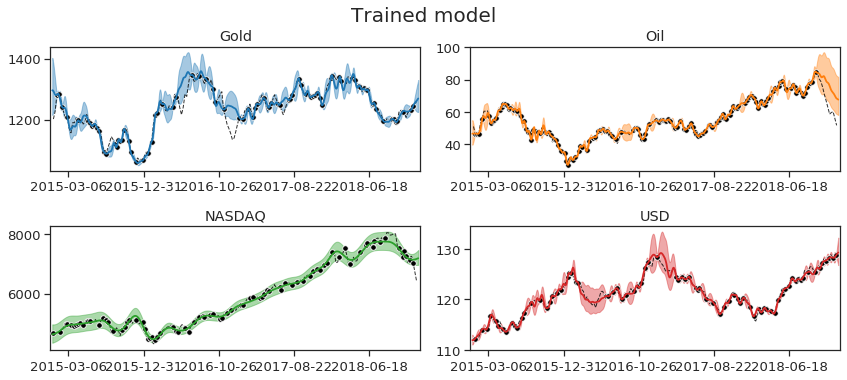

In [11]:
# set prediction range
for channel in dataset:
    channel.set_prediction_range(start='2015-01-01', end='2018-12-31', step='1d')

# plot predictions
model.predict()
model.plot_prediction(title='Trained model');